In [301]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from PhysPropWater import rho
from sklearn.preprocessing import MinMaxScaler
import pickle

In [302]:
torch.manual_seed(42)
np.random.seed(42)
scaler = MinMaxScaler()

In [303]:
with open('reacdata.pc','rb') as f:
    data = pickle.load(f)

# Stacking the two arrays column-wise and converting them to a torch tensor
combined_data = np.column_stack((data['pH'], data['ratio S/A']))
X = torch.tensor(combined_data, dtype=torch.float32)
X1 = torch.tensor(data['pH'], dtype=torch.float32).view(-1, 1)
X2 = torch.tensor(data['ratio S/A'], dtype=torch.float32).view(-1, 1)
y = torch.tensor(data['yield'], dtype=torch.float32).view(-1, 1)
y_scaled = scaler.fit_transform(y)
y_scaled_tensor = torch.tensor(y_scaled, dtype=torch.float32)

y_bin = torch.zeros_like(y)
y_bin[y > 0.45] = 1

X_scaled = scaler.fit_transform(X)

In [304]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 20),
            nn.ReLU(),
            nn.Linear(20, 50),
            nn.ReLU(),
            nn.Linear(50, 20),
            nn.ReLU(),
            nn.Linear(20, 1),
            nn.Sigmoid()    
        )
        
    def forward(self, x):
        return self.model(x)
    
class ModelB(nn.Module):
    def __init__(self):
        super(ModelB, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(1, 20),
            nn.ReLU(),
            nn.Linear(20, 50),
            nn.ReLU(),
            nn.Linear(50, 20),
            nn.ReLU(),
            nn.Linear(20, 1),   
        )
        
    def forward(self, x):
        return self.model(x)

In [305]:
model = Model()
modelB = ModelB()
loss_fn = nn.BCELoss()
optimizer = optim.Adam(model.parameters())

In [306]:
# Train the model

EPOCS = 5000
losses = []  # List to store loss values for each epoch

print("Starting training...")

for epoch in range(EPOCS):
    optimizer.zero_grad()
    #y_pred = modelB(X)
    y_pred = model(y_scaled_tensor)
    loss = loss_fn(y_pred, y)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    
    # Print the loss every 500 epochs to monitor training
    if epoch % 500 == 0:
        print(f"Epoch {epoch}/{EPOCS} - Loss: {loss.item()}")

    #if epoch > 300:
    #    diff = losses[-300] - losses[-1]
    #    if diff > 0 and diff <= 5e-5:
    #        print(f"Model converged after {epoch} epochs\nLoss: {loss.item()}\nDerivative: {losses[-300] - losses[-1] / len(losses[-300:-1])}")
    #        break

    

print("Training completed.")

Starting training...


RuntimeError: mat1 and mat2 shapes cannot be multiplied (200x1 and 2x20)

Ncorrect: 179
Nsamples: 200
Accuracy: 0.8949999809265137


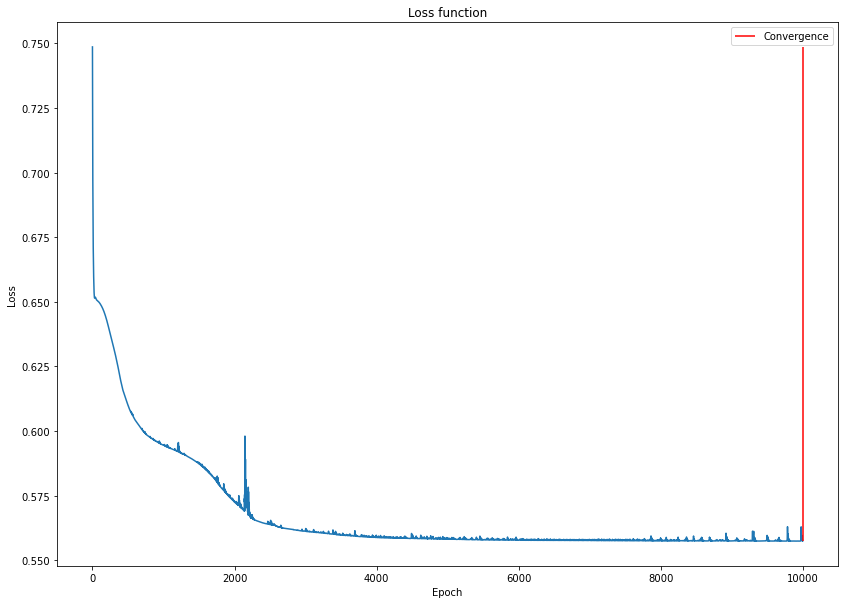

In [ ]:
y_pred = model(X)
#print(y_pred)
y_bin_pred = torch.zeros_like(y_pred)
y_bin_pred[y_pred > 0.5] = 1
#print(y_bin_pred)
Ncorrect = torch.sum(y_bin_pred == y_bin)
Nsamples = y_bin.shape[0]
acc = Ncorrect/Nsamples
print(f"Ncorrect: {Ncorrect}")
print(f"Nsamples: {Nsamples}")
print(f"Accuracy: {acc}")

# Plot the loss function

fig, ax = plt.subplots(figsize=(14, 10))

#loss function
ax.plot(losses)
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_title("Loss function")
ax.vlines(epoch, losses[-1], max(losses), color='red', label='Convergence')
ax.legend()

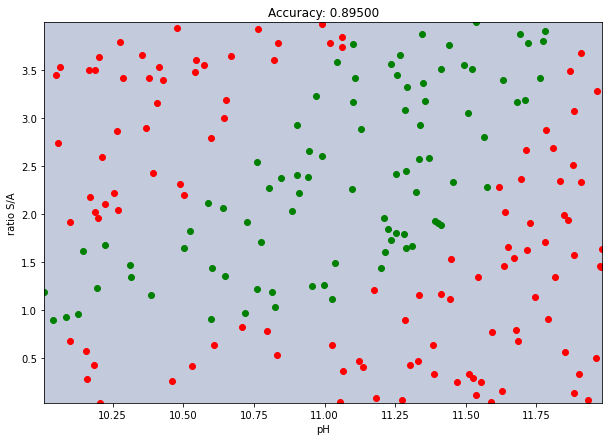

In [ ]:
plt.figure(figsize=(10, 7))

for i in range(len(X1)):
    if y_bin[i]: # 1
        plt.plot(X1[i], X2[i], 'go')
    else: # 0
        plt.plot(X1[i], X2[i], 'ro')

# Create finely gridded x1 and x2
Ngrid = 100
x1_fine = np.linspace(X1.min().item(), X1.max().item(), Ngrid)
x2_fine = np.linspace(X2.min().item(), X2.max().item(), Ngrid)
X1_fine, X2_fine = np.meshgrid(x1_fine, x2_fine)
# Combine them to a matrix instead for speed
X_fine = np.vstack((X1_fine.flatten(),X2_fine.flatten())).T

X_fine_scaled = scaler.transform(X_fine)  # Use transform, not fit_transform
X_fine_scaled_tensor = torch.tensor(X_fine_scaled, dtype=torch.float32)
y_fine = model(X_fine_scaled_tensor)
# Make it binary
y_fine_binary = (y_fine.detach().numpy() > 0.5).astype(int)
# Reshape it as a matrix
Y_binary = y_fine_binary.reshape((Ngrid, Ngrid))

plt.contourf(X1_fine, X2_fine, Y_binary, levels=[0, 0.5, 1], alpha=0.3) # Use contourf with alpha for better visualization
plt.xlabel('pH')
plt.ylabel('ratio S/A')
plt.title(f'Accuracy: {acc:.5f}')
plt.show()